In [1]:
import sys
root_dir = !cd .. &&pwd
root_dir = root_dir[0] + "/"
sys.path.insert(0, root_dir)

In [2]:
print(root_dir)

/Users/gunder/Desktop/bachelor_project/


### Imports

In [3]:
import os
import torch
import matplotlib.pyplot as plt
from our_modules.eval_tools import load_and_eval_mls_osr
from our_modules.plot_tools import plot_roc

### Setting the Device

In [4]:
if sys.platform == 'darwin':
    device = torch.device("mps")
else:
    gpu = torch.cuda.is_available()
    device = torch.device("cuda:0" if gpu else "cpu")

print("device:", device)

device: mps


In [15]:
roc_stats_plain, _ = load_and_eval_mls_osr(root_dir + "logits/tinyimagenet/plain/logits_split_0.pt", root_dir + "logits/tinyimagenet/plain/csr_targets_split_0.pt",
                      0, dataset_name='tinyimagenet')
roc_stats_fp, _ = load_and_eval_mls_osr(root_dir + "logits/tinyimagenet/fgsm_fp_attack/logits_split_0.pt", root_dir + "logits/tinyimagenet/plain/csr_targets_split_0.pt",
                                      0, dataset_name='tinyimagenet')
roc_stats_fn, _ = load_and_eval_mls_osr(root_dir + "logits/tinyimagenet/fgsm_fn_attack/logits_split_0.pt", root_dir + "logits/tinyimagenet/plain/csr_targets_split_0.pt",
                                      0, dataset_name='tinyimagenet')

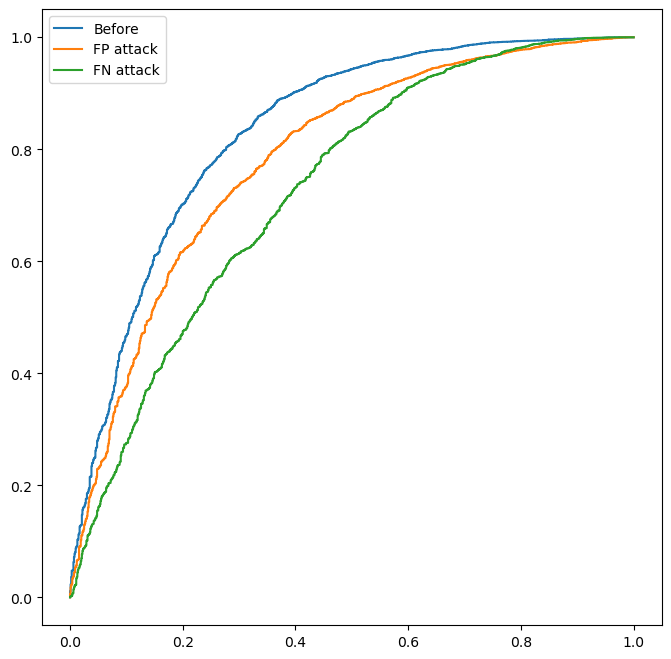

In [17]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
plot_roc(ax, roc_stats_plain, label='Before')
plot_roc(ax, roc_stats_fp, label="FP attack")
plot_roc(ax, roc_stats_fn, label="FN attack")
plt.legend()
plt.show()